In [1]:
###############################
## This script links the flood sum map that was generated in GEE to the corresponding flood frequenices 
## for the Prek Area 
## exüprted from this script: https://code.earthengine.google.com/f69af6afbec2c0a5d43a173a965c67be

In [2]:
# import necessary packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from io import StringIO
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math
from matplotlib.dates import date2num
from pandas import DataFrame

In [3]:
# water level at Koh Kehl 

wl_long = pd.read_csv('wl_KK.csv')
wl_long['date'] = pd.to_datetime(wl_long['date'])
wl_long['date'] = wl_long['date'].dt.strftime('%Y-%m-%d')
wl_long.columns = ['huh', 'date', 'wl_long']
wl_long = wl_long.drop(columns=['huh'])
wl_long = wl_long.set_index('date')
wl_long['wl_long'] = wl_long['wl_long']-1 # <------ -1 correct for elevation 

# for data availability comparison:
wl_long.index = pd.to_datetime(wl_long.index)
wl_long1 = wl_long.resample('d').mean()

wl_KK_daily = wl_long1  
wl_KK_daily.columns = ['wl_KK']
wl_original = wl_KK_daily

wl_KK_daily = wl_KK_daily.rolling(center=False, window=3, min_periods=1).mean().round(2)

#wl_KK_daily.to_csv('wl_KK_smoothed.csv')

wl_KK_daily.head()

,wl_KK
date,
1990-09-05,7.16
1990-09-06,7.18
1990-09-07,7.19
1990-09-08,7.21
1990-09-09,7.22


In [4]:
### add data and functions to calculate delay times 

# Prek Area: calculate the delay times according to water levels for each image 

delay_PA = pd.read_csv('Inundations_WaterLevels_PA.csv', sep=';', decimal=',').round(2)
delay_PA.head(3)

mean_delay_PA = delay_PA['DelayTime'].mean()
#print(mean_delay_PA)

# Zone 2C: calculate the delay times according to water levels for each image 

delay_2C = pd.read_csv('Inundations_WaterLevels_2C.csv', sep=';', decimal=',').round(2)
delay_2C.head(10)

mean_delay_2C = delay_2C['DelayTime'].mean()
#print(mean_delay_2C)

# for each water level in KK, find the date that matches it, according to the table  - then check, if there is a Sentinel image for that day in the collection

def find_delay_PA(wl):
    test_value = wl
    df_temp = delay_PA.iloc[(delay_PA['WL']-test_value).abs().argsort()[:1]] #<--- match wl
    time_days = int(df_temp['DelayTime'].round(0)) #<- select corresponding delay
    return time_days

def find_delay_2C(wl):
    test_value = wl
    df_temp = delay_2C.iloc[(delay_2C['WL']-test_value).abs().argsort()[:1]] #<--- match wl
    time_days = int(df_temp['DelayTime'].round(0)) #<- select corresponding delay
    return time_days

## add the individual inundation delays for each wl value at KK - convert to list of dates 

wl_KK_daily['date'] = wl_KK_daily.index
wl_KK_daily['delay_PA'] = wl_KK_daily['wl_KK'].apply(find_delay_PA)
wl_KK_daily['delay_2C'] = wl_KK_daily['wl_KK'].apply(find_delay_2C)
wl_KK_daily['delay_PA'] = pd.to_timedelta(wl_KK_daily['delay_PA'], unit='d')
wl_KK_daily['Sentinel_date_PA'] = wl_KK_daily['date']+ wl_KK_daily['delay_PA']
wl_KK_daily['delay_2C'] = pd.to_timedelta(wl_KK_daily['delay_2C'], unit='d')
wl_KK_daily['Sentinel_date_2C'] = wl_KK_daily['date']+ wl_KK_daily['delay_2C']
wl_KK_daily = wl_KK_daily.drop(columns=['delay_PA'])
wl_KK_daily = wl_KK_daily.drop(columns=['delay_2C'])

#wl_KK_daily['new_date'] = (wl_KK_daily['date'] + datetime.timedelta(days=wl_KK_daily['delay']))

wl_KK_daily.tail(10)

,wl_KK,date,Sentinel_date_PA,Sentinel_date_2C
date,,,,
2021-03-13,0.88,2021-03-13,2021-03-27,2021-04-07
2021-03-14,0.93,2021-03-14,2021-03-23,2021-04-07
2021-03-15,0.96,2021-03-15,2021-03-24,2021-04-08
2021-03-16,0.98,2021-03-16,2021-03-25,2021-04-09
2021-03-17,1.00,2021-03-17,2021-03-26,2021-04-10
2021-03-18,1.01,2021-03-18,2021-03-27,2021-04-11
2021-03-19,1.00,2021-03-19,2021-03-28,2021-04-12
2021-03-20,0.99,2021-03-20,2021-03-29,2021-04-13
2021-03-21,0.97,2021-03-21,2021-03-30,2021-04-14


In [5]:
print(wl_KK_daily[(wl_KK_daily['Sentinel_date_2C']=='1995-10-23')])

            wl_KK       date Sentinel_date_PA Sentinel_date_2C
date                                                          
1995-10-01    6.3 1995-10-01       1995-10-17       1995-10-23


In [6]:
##### import list of dates from GEE => in this case SPLIT UP 


###################
### 2017 
###################

dates_GEE = pd.read_csv('Datesofimages_PA_2017.csv')

dates_GEE = dates_GEE.drop(columns=['system:index', '.geo'])
dates_GEE.columns = ['list']

#dates_GEE = dates_GEE['list']

dates_GEE = dates_GEE['list'].iloc[-1]

dates = StringIO(dates_GEE)

df = pd.read_csv(dates, sep=",").T

df['date'] = df.index

#df.columns = ['date']

df = df.reset_index()

#df['number'] = df.index

df = df.drop(columns=['index'])

df['date'] = df['date'].map(lambda x: x.lstrip('[').rstrip(']'))

df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

#df = df[~df.index.duplicated(keep='first')]

dates_GEE_2017 = df



###################
### 2018
###################
dates_GEE = pd.read_csv('Datesofimages_PA_2018.csv')

dates_GEE = dates_GEE.drop(columns=['system:index', '.geo'])
dates_GEE.columns = ['list']

#dates_GEE = dates_GEE['list']

dates_GEE = dates_GEE['list'].iloc[-1]

dates = StringIO(dates_GEE)

df = pd.read_csv(dates, sep=",").T

df['date'] = df.index

#df.columns = ['date']

df = df.reset_index()

#df['number'] = df.index

df = df.drop(columns=['index'])

df['date'] = df['date'].map(lambda x: x.lstrip('[').rstrip(']'))

df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

#df = df[~df.index.duplicated(keep='first')]

dates_GEE_2018 = df



###################
### 2019
###################
dates_GEE = pd.read_csv('Datesofimages_PA_2019.csv')

dates_GEE = dates_GEE.drop(columns=['system:index', '.geo'])
dates_GEE.columns = ['list']

#dates_GEE = dates_GEE['list']

dates_GEE = dates_GEE['list'].iloc[-1]

dates = StringIO(dates_GEE)

df = pd.read_csv(dates, sep=",").T

df['date'] = df.index

#df.columns = ['date']

df = df.reset_index()

#df['number'] = df.index

df = df.drop(columns=['index'])

df['date'] = df['date'].map(lambda x: x.lstrip('[').rstrip(']'))

df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

#df = df[~df.index.duplicated(keep='first')]

dates_GEE_2019 = df



###################
### 2020
###################
dates_GEE = pd.read_csv('Datesofimages_PA_2020.csv')

dates_GEE = dates_GEE.drop(columns=['system:index', '.geo'])
dates_GEE.columns = ['list']

#dates_GEE = dates_GEE['list']

dates_GEE = dates_GEE['list'].iloc[-1]

dates = StringIO(dates_GEE)

df = pd.read_csv(dates, sep=",").T

df['date'] = df.index

#df.columns = ['date']

df = df.reset_index()

#df['number'] = df.index

df = df.drop(columns=['index'])

df['date'] = df['date'].map(lambda x: x.lstrip('[').rstrip(']'))

df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

#df = df[~df.index.duplicated(keep='first')]


dates_GEE_2020 = df

###################
### Cobble everything together 
###################


df = dates_GEE_2017.append(dates_GEE_2018).append(dates_GEE_2019).append(dates_GEE_2020)


df = df.set_index('date')

df = df[~df.index.duplicated(keep='first')]


df.tail()


df.head()
## so far, there ARE 58 dates in here! 

""
date
2000-10-20
2011-09-17
2017-05-17
2017-05-29
2017-06-10


In [7]:
##### match them to the water levels at KK at the correct date

wl_KK_PA = wl_KK_daily.set_index('Sentinel_date_PA') # set the PA date to index

wl_KK_PA = wl_KK_daily.sort_values('wl_KK') # sort by water level 

wl_KK_PA = wl_KK_PA[~wl_KK_PA.index.duplicated(keep='first')] # get rid of duplicates

flood_link = df.merge(wl_KK_PA, how='inner', left_index=True, right_index=True)

flood_link = flood_link.drop(columns=['Sentinel_date_2C'])

flood_link = flood_link.sort_values('wl_KK',ascending=False)

flood_link['image_date'] = flood_link.index

flood_link = flood_link[~flood_link.index.duplicated(keep='first')]

flood_link.index = np.arange(1, len(flood_link) + 1)

flood_link['count_reached'] = flood_link.index

flood_link_original = flood_link

flood_link.tail()

#flood_link.to_csv('notworking_cut.csv')

,wl_KK,date,Sentinel_date_PA,image_date,count_reached
78,0.84,2019-05-31,2019-06-14,2019-05-31,78
79,0.80,2020-06-06,2020-06-20,2020-06-06,79
80,0.77,2020-05-25,2020-05-26,2020-05-25,80
81,0.68,2020-06-19,2020-06-20,2020-06-19,81
82,0.60,2020-06-18,2020-06-19,2020-06-18,82


In [8]:
flood_link = flood_link.set_index('Sentinel_date_PA')

flood_link = flood_link[~flood_link.index.duplicated(keep='first')]

flood_link.index = np.arange(1, len(flood_link) + 1)

flood_link.tail()



,wl_KK,date,image_date,count_reached
77,0.84,2020-05-26,2020-05-26,77
78,0.84,2019-05-31,2019-05-31,78
79,0.80,2020-06-06,2020-06-06,79
80,0.77,2020-05-25,2020-05-25,80
81,0.60,2020-06-18,2020-06-18,82


In [9]:
wl_original['date'] = wl_original.index
wl_original['date'] = pd.to_datetime(wl_original['date'])
wl_original['monthday'] = wl_original['date'].dt.strftime('%m-%d')
wl_original['year'] = wl_original['date'].dt.strftime('%Y')

### define function that counts how many times in this time range, 
### a certain value was exceeded by the test date! 

def counting_times_reached(wl):
        list1 = []
        for year in years: 
            year = str(year)
            wl_year = wl_original[(wl_original['year']==year)] # filter for year 
            wl_decide = wl_year[(wl_year['monthday']<=testdate)] # filter before date
            #wl_min = wl_decide1['wl_long'].min()
            #date_min = wl_decide1[(wl_decide1.wl_long==wl_min).idxmax()]['date']  
            #wl_decide = wl_decide1[(wl_decide1['date'] > date_min)] # after dry season min
            check = (wl_decide['wl_KK'] >= wl).any()#.astype(int) # check if present
            list1.append(check)
        total_sum = float(sum(list1))/float(len(years))
        return total_sum
    

In [10]:
wl_90s = wl_original[(wl_original['year']<='2000')& (wl_original['year']>'1990')]
wl_00s = wl_original[(wl_original['year']>'2000')&(wl_original['year']<='2010')]
wl_10s = wl_original[(wl_original['year'] > '2010') & (wl_original['year']<='2020')]
wl_pre08 = wl_original[(wl_original['year'] <= '2008')]
wl_post08 = wl_original[(wl_original['year'] > '2008')]


years1 = wl_90s.year.unique()
years2 = wl_00s.year.unique()
years3 = wl_10s.year.unique()

print(years1)
print(years2)
print(years3)


['1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000']
['2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010']
['2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020']


In [11]:
#### implement the function for the OVERALL time period 1990-2021

flood_link = flood_link_original

years = wl_original.year.unique()

testdate = '11-31'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-31'
flood_link['freq_Aug31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '09-15'
flood_link['freq_Sep25'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

flood_link.to_csv('flood_link_GEE_PA_overall')
flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('flood_link_GEE_PA_overall.xlsx', index=False)


### split into lookup tables 

### water level 

PA_OA_wl = pd.DataFrame()

PA_OA_wl['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_OA_wl['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_OA_wl['Value'] = flood_link['wl_KK'].astype(float)

PA_OA_wl.to_excel('PA_OA_wl.xlsx', index=False)

#### overall 

PA_OA_OA = pd.DataFrame()

PA_OA_OA['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_OA_OA['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_OA_OA['Value'] = flood_link['freq_overall'].astype(float)

PA_OA_OA.to_excel('PA_OA_OA.xlsx', index=False)


##### July 15 
PA_OA_J15 = pd.DataFrame()

PA_OA_J15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_OA_J15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_OA_J15['Value'] = flood_link['freq_Jul15'].astype(float)

PA_OA_J15.to_excel('PA_OA_J15.xlsx', index=False)


#### July 31

PA_OA_J31 = pd.DataFrame()

PA_OA_J31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_OA_J31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_OA_J31['Value'] = flood_link['freq_Jul31'].astype(float)

PA_OA_J31.to_excel('PA_OA_J31.xlsx', index=False)


#### Aug 15 
PA_OA_A15 = pd.DataFrame()

PA_OA_A15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_OA_A15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_OA_A15['Value'] = flood_link['freq_Aug15'].astype(float)

PA_OA_A15.to_excel('PA_OA_A15.xlsx', index=False)


#### Aug 31
PA_OA_A31 = pd.DataFrame()

PA_OA_A31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_OA_A31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_OA_A31['Value'] = flood_link['freq_Aug31'].astype(float)

PA_OA_A31.to_excel('PA_OA_A31.xlsx', index=False)


#### Sep 25

PA_OA_S25 = pd.DataFrame()

PA_OA_S25['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_OA_S25['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_OA_S25['Value'] = flood_link['freq_Sep25'].astype(float)

PA_OA_S25.to_excel('PA_OA_S25.xlsx', index=False)



In [12]:
#### implement the function for the OVERALL time period 1990-2021

flood_link = flood_link_original

years = wl_90s.year.unique()

testdate = '11-31'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-31'
flood_link['freq_Aug31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '09-15'
flood_link['freq_Sep25'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 


flood_link.to_csv('flood_link_GEE_PA_90s')
flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('flood_link_GEE_PA_90s.xlsx', index=False)


### split into lookup tables 




### overall 

PA_90s_OA = pd.DataFrame()

PA_90s_OA['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_90s_OA['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_90s_OA['Value'] = flood_link['freq_overall'].astype(float)

PA_90s_OA.to_excel('PA_90s_OA.xlsx', index=False)


##### July 15 
PA_90s_J15 = pd.DataFrame()

PA_90s_J15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_90s_J15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_90s_J15['Value'] = flood_link['freq_Jul15'].astype(float)

PA_90s_J15.to_excel('PA_90s_J15.xlsx', index=False)


#### July 31

PA_90s_J31 = pd.DataFrame()

PA_90s_J31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_90s_J31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_90s_J31['Value'] = flood_link['freq_Jul31'].astype(float)

PA_90s_J31.to_excel('PA_90s_J31.xlsx', index=False)


#### Aug 15 
PA_90s_A15 = pd.DataFrame()

PA_90s_A15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_90s_A15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_90s_A15['Value'] = flood_link['freq_Aug15'].astype(float)

PA_90s_A15.to_excel('PA_90s_A15.xlsx', index=False)


#### Aug 31
PA_90s_A31 = pd.DataFrame()

PA_90s_A31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_90s_A31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_90s_A31['Value'] = flood_link['freq_Aug31'].astype(float)

PA_90s_A31.to_excel('PA_90s_A31.xlsx', index=False)


#### Sep 25

PA_90s_S25 = pd.DataFrame()

PA_90s_S25['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_90s_S25['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_90s_S25['Value'] = flood_link['freq_Sep25'].astype(float)

PA_90s_S25.to_excel('PA_90s_S25.xlsx', index=False)



In [13]:
#### implement the function for the 00s time period 1990-2021

flood_link = flood_link_original

years = wl_00s.year.unique()

testdate = '11-31'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-31'
flood_link['freq_Aug31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '09-15'
flood_link['freq_Sep25'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 


flood_link.to_csv('flood_link_GEE_PA_00s')
flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('flood_link_GEE_PA_00s.xlsx', index=False)

### split into lookup tables 



### overall 

PA_00s_OA = pd.DataFrame()

PA_00s_OA['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_00s_OA['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_00s_OA['Value'] = flood_link['freq_overall'].astype(float)

PA_00s_OA.to_excel('PA_00s_OA.xlsx', index=False)


##### July 15 
PA_00s_J15 = pd.DataFrame()

PA_00s_J15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_00s_J15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_00s_J15['Value'] = flood_link['freq_Jul15'].astype(float)

PA_00s_J15.to_excel('PA_00s_J15.xlsx', index=False)


#### July 31

PA_00s_J31 = pd.DataFrame()

PA_00s_J31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_00s_J31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_00s_J31['Value'] = flood_link['freq_Jul31'].astype(float)

PA_00s_J31.to_excel('PA_00s_J31.xlsx', index=False)


#### Aug 15 
PA_00s_A15 = pd.DataFrame()

PA_00s_A15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_00s_A15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_00s_A15['Value'] = flood_link['freq_Aug15'].astype(float)

PA_00s_A15.to_excel('PA_00s_A15.xlsx', index=False)


#### Aug 31
PA_00s_A31 = pd.DataFrame()

PA_00s_A31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_00s_A31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_00s_A31['Value'] = flood_link['freq_Aug31'].astype(float)

PA_00s_A31.to_excel('PA_00s_A31.xlsx', index=False)


#### Sep 25

PA_00s_S25 = pd.DataFrame()

PA_00s_S25['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_00s_S25['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_00s_S25['Value'] = flood_link['freq_Sep25'].astype(float)

PA_00s_S25.to_excel('PA_00s_S25.xlsx', index=False)


In [14]:
#### implement the function for the OVERALL time period 1990-2021

flood_link = flood_link_original

years = wl_10s.year.unique()

testdate = '11-31'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-31'
flood_link['freq_Aug31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '09-15'
flood_link['freq_Sep25'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

flood_link.to_csv('flood_link_GEE_PA_10s')
flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('flood_link_GEE_PA_10s.xlsx', index=False)

### split into lookup tables 



#### overall

PA_10s_OA = pd.DataFrame()

PA_10s_OA['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_10s_OA['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_10s_OA['Value'] = flood_link['freq_overall'].astype(float)

PA_10s_OA.to_excel('PA_10s_OA.xlsx', index=False)


##### July 15 
PA_10s_J15 = pd.DataFrame()

PA_10s_J15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_10s_J15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_10s_J15['Value'] = flood_link['freq_Jul15'].astype(float)

PA_10s_J15.to_excel('PA_10s_J15.xlsx', index=False)


#### July 31

PA_10s_J31 = pd.DataFrame()

PA_10s_J31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_10s_J31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_10s_J31['Value'] = flood_link['freq_Jul31'].astype(float)

PA_10s_J31.to_excel('PA_10s_J31.xlsx', index=False)


#### Aug 15 
PA_10s_A15 = pd.DataFrame()

PA_10s_A15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_10s_A15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_10s_A15['Value'] = flood_link['freq_Aug15'].astype(float)

PA_10s_A15.to_excel('PA_10s_A15.xlsx', index=False)


#### Aug 31
PA_10s_A31 = pd.DataFrame()

PA_10s_A31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_10s_A31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_10s_A31['Value'] = flood_link['freq_Aug31'].astype(float)

PA_10s_A31.to_excel('PA_10s_A31.xlsx', index=False)


#### Sep 25

PA_10s_S25 = pd.DataFrame()

PA_10s_S25['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_10s_S25['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_10s_S25['Value'] = flood_link['freq_Sep25'].astype(float)

PA_10s_S25.to_excel('PA_10s_S25.xlsx', index=False)



In [18]:
#### implement the function for the OVERALL time period 1990-2021

flood_link = flood_link_original

years = wl_pre08.year.unique()

testdate = '11-31'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-31'
flood_link['freq_Aug31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '09-15'
flood_link['freq_Sep25'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 


flood_link.to_csv('flood_link_GEE_PA_pre08')
flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('flood_link_GEE_PA_pre08.xlsx', index=False)

### split into lookup tables 



#### overall

PA_pre08_OA = pd.DataFrame()

PA_pre08_OA['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_pre08_OA['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_pre08_OA['Value'] = flood_link['freq_overall'].astype(float)

PA_pre08_OA.to_excel('PA_pre08_OA.xlsx', index=False)


##### July 15 
PA_pre08_J15 = pd.DataFrame()

PA_pre08_J15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_pre08_J15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_pre08_J15['Value'] = flood_link['freq_Jul15'].astype(float)

PA_pre08_J15.to_excel('PA_pre08_J15.xlsx', index=False)


#### July 31

PA_pre08_J31 = pd.DataFrame()

PA_pre08_J31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_pre08_J31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_pre08_J31['Value'] = flood_link['freq_Jul31'].astype(float)

PA_pre08_J31.to_excel('PA_pre08_J31.xlsx', index=False)


#### Aug 15 
PA_pre08_A15 = pd.DataFrame()

PA_pre08_A15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_pre08_A15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_pre08_A15['Value'] = flood_link['freq_Aug15'].astype(float)

PA_pre08_A15.to_excel('PA_pre08_A15.xlsx', index=False)


#### Aug 31
PA_pre08_A31 = pd.DataFrame()

PA_pre08_A31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_pre08_A31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_pre08_A31['Value'] = flood_link['freq_Aug31'].astype(float)

PA_pre08_A31.to_excel('PA_pre08_A31.xlsx', index=False)


#### Sep 25

PA_pre08_S25 = pd.DataFrame()

PA_pre08_S25['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_pre08_S25['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_pre08_S25['Value'] = flood_link['freq_Sep25'].astype(float)

PA_pre08_S25.to_excel('PA_pre08_S25.xlsx', index=False)




In [17]:
#### implement the function for the OVERALL time period 1990-2021

flood_link = flood_link_original

years = wl_post08.year.unique()

testdate = '11-31'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '08-31'
flood_link['freq_Aug31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '09-15'
flood_link['freq_Sep25'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

flood_link.to_csv('flood_link_GEE_PA_post08')
flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('flood_link_GEE_PA_post08.xlsx', index=False)

### split into lookup tables 



#### overall

PA_post08_OA = pd.DataFrame()

PA_post08_OA['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_post08_OA['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_post08_OA['Value'] = flood_link['freq_overall'].astype(float)

PA_post08_OA.to_excel('PA_post08_OA.xlsx', index=False)


##### July 15 
PA_post08_J15 = pd.DataFrame()

PA_post08_J15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_post08_J15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_post08_J15['Value'] = flood_link['freq_Jul15'].astype(float)

PA_post08_J15.to_excel('PA_post08_J15.xlsx', index=False)


#### July 31

PA_post08_J31 = pd.DataFrame()

PA_post08_J31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_post08_J31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_post08_J31['Value'] = flood_link['freq_Jul31'].astype(float)

PA_post08_J31.to_excel('PA_post08_J31.xlsx', index=False)


#### Aug 15 
PA_post08_A15 = pd.DataFrame()

PA_post08_A15['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_post08_A15['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_post08_A15['Value'] = flood_link['freq_Aug15'].astype(float)

PA_post08_A15.to_excel('PA_post08_A15.xlsx', index=False)


#### Aug 31
PA_post08_A31 = pd.DataFrame()

PA_post08_A31['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_post08_A31['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_post08_A31['Value'] = flood_link['freq_Aug31'].astype(float)

PA_post08_A31.to_excel('PA_post08_A31.xlsx', index=False)


#### Sep 25

PA_post08_S25 = pd.DataFrame()

PA_post08_S25['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
PA_post08_S25['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
PA_post08_S25['Value'] = flood_link['freq_Sep25'].astype(float)

PA_post08_S25.to_excel('PA_post08_S25.xlsx', index=False)





In [17]:
def average_inundation_duration(i): 
    
    ### make empty list 
    list1 = []
    
    ### get average duration for each year 
    
    for y in years: 

            #######
            # Get the wet season / dry season duration for year n & n+1 
            #######
            
            # cut to year y 
            wlnew = wl_original[(wl_original['year'] == y)] 
            
            # get minimum water level (height of dry season)
            wl_min = wlnew['wl_KK'].min() 
            
            # find the date that was reached 
            date_min = wlnew.loc[(wlnew.wl_KK==wl_min).idxmax()]['date']  # get date of miimum level
           
            # cut the series to after that date 
            wl_new_1 = wlnew[(wlnew['date']> date_min)] # cut to after the peak of the dry season 
            


            #######
            # Find the end of the dry season in the subsequent year 
            #######


            ### get the series for the subsequent year 
            
            # get subsequent year 
            year_n1 = int(y)+1
            year_n1 = str(year_n1)
            wl_yn1 = wl_original[(wl_original['year'] == year_n1)]
            
            # find minimum level that year 
            wl_min = wl_yn1['wl_KK'].min()
            
            # get date of minimum level 
            date_min = wl_yn1.loc[(wl_yn1.wl_KK==wl_min).idxmax()]['date']  
            
            # cut to before that date 
            wl_new_2 = wl_yn1[(wl_yn1['date'] <= date_min)]
            

            ## concatenate 

            wl_filter = pd.concat([wl_new_2, wl_new_1], axis=0)


            #######
            # threshold for the dates when the wl was above! 
            #######


            wl_above = wl_filter[(wl_filter['wl_KK'])>= i]
            
            wl_above_nr = len(wl_above.index)
            
            ## append to list 
            
            list1.append(wl_above_nr)
            

    average_duration = float(sum(list1))/float(len(years))
        
    return average_duration 

###### calculate average flood durations for all water levels for each decade 


duration_link = flood_link_original.drop(columns=['date', 'image_date', 'freq_overall', 'freq_Jul15', 'freq_Jul31', 'freq_Aug15', 'freq_Aug31', 'freq_Sep25'])

#duration_link = duration_link.set_index('wl_KK')

years = ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
duration_link['overall'] = duration_link['wl_KK'].apply(average_inundation_duration)

years = ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000']
duration_link['90s'] = duration_link['wl_KK'].apply(average_inundation_duration)

years = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010']
duration_link['00s'] = duration_link['wl_KK'].apply(average_inundation_duration)

years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
duration_link['10s'] = duration_link['wl_KK'].apply(average_inundation_duration)

years = ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008']
duration_link['pre08'] = duration_link['wl_KK'].apply(average_inundation_duration)

years = ['2009', '2010','2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
duration_link['post08'] = duration_link['wl_KK'].apply(average_inundation_duration)


duration_link.head(31)

duration_link.to_excel('PA_flood_duration.xlsx', index=False)
duration_link.to_csv('PA_flood_duration.csv')


In [9]:
wl_original['date'] = wl_original.index
wl_original['date'] = pd.to_datetime(wl_original['date'])
wl_original['monthday'] = wl_original['date'].dt.strftime('%m-%d')
wl_original['year'] = wl_original['date'].dt.strftime('%Y')

### define function that counts how many times in this time range, 
### a certain value was exceeded by the test date! 

def counting_times_reached(wl):
        list1 = []
        for y in years: 
            
            year = str(y)
            
             #######
            # Get the wet season / dry season duration for year n & n+1 
            #######
            
            # cut to year y 
            wlnew = wl_original[(wl_original['year'] == y)] 
            
            # get maximum water level (height of dry season)
            wl_max = wlnew['wl_KK'].max() 
            
            # find the date that was reached 
            date_max = wlnew.loc[(wlnew.wl_KK==wl_max).idxmax()]['date']  # get date of miimum level
           
            # cut the series to after that date 
            wl_filter = wlnew[(wlnew['date']> date_max)] # cut to after the peak of the dry season 
            

            #######
            # Find the end of the dry season in the subsequent year 
            #######


            ### get the series for the subsequent year 
            
            # get subsequent year 
            #year_n1 = int(y)+1
            #year_n1 = str(year_n1)
            #wl_yn1 = wl_original[(wl_original['year'] == year_n1)]
            
            # find minimum level that year 
            #wl_min = wl_yn1['wl_KK'].min()
            
            # get date of minimum level 
            #date_min = wl_yn1.loc[(wl_yn1.wl_KK==wl_min).idxmax()]['date']  
            #
            # cut to before that date 
            #wl_new_2 = wl_yn1[(wl_yn1['date'] <= date_min)]
            

            ## concatenate 

            #wl_filter = pd.concat([wl_new_2, wl_new_1], axis=0)
            
            ## cut the series to BEFORE the test date 
            
            wl_check = wl_filter[(wl_filter['monthday']<=testdate)]
            
            ## check whether the water level that causes inundation had NOT been reached anymore 
            
            check = (wl_check['wl_KK'] <= wl).any()#.astype(int) # check if present
            
            list1.append(check)
            
        total_sum = 1-(float(sum(list1))/float(len(years)))
        
        return total_sum
    




In [10]:
#### implement the function for the OVERALL time period 1990-2021



################# overall: 

flood_link = flood_link_original

years = ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']


testdate = '12-01'
flood_link['freq_Dec1'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '12-15'
flood_link['freq_Dec15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '12-31'
flood_link['freq_Jan1'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 


flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('ForJP_flood_link_PA_overall_JP.xlsx', index=False)

############### early 90s: 

flood_link = flood_link_original

years = ['1991', '1992', '1993', '1994', '1995', '1996']

testdate = '12-01'
flood_link['freq_Dec1'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '12-15'
flood_link['freq_Dec15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '12-31'
flood_link['freq_Jan1'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 


flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('ForJP_flood_link_PA_early90s.xlsx', index=False)

################### 2000 - 2020: 


flood_link = flood_link_original

years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

testdate = '12-01'
flood_link['freq_Dec1'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '12-15'
flood_link['freq_Dec15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '12-31'
flood_link['freq_Jan1'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)

flood_link.to_excel('ForJP_flood_link_PA_00_20.xlsx', index=False)


###################### late 2010s: 
flood_link = flood_link_original

years = ['2015', '2016', '2017', '2018', '2019', '2020']

testdate = '12-01'
flood_link['freq_Dec1'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '12-15'
flood_link['freq_Dec15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '12-31'
flood_link['freq_Jan1'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 


flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('ForJP_flood_link_PA_late_10s.xlsx', index=False)

In [11]:
### define function that counts how many times in this time range, 
### a certain value was exceeded by the test date! 

def counting_times_reached(wl):
        list1 = []
        for year in years: 
            year = str(year)
            wl_year = wl_original[(wl_original['year']==year)] # filter for year 
            wl_decide = wl_year[(wl_year['monthday']<=testdate)] # filter before date
            #wl_min = wl_decide1['wl_long'].min()
            #date_min = wl_decide1[(wl_decide1.wl_long==wl_min).idxmax()]['date']  
            #wl_decide = wl_decide1[(wl_decide1['date'] > date_min)] # after dry season min
            check = (wl_decide['wl_KK'] >= wl).any()#.astype(int) # check if present
            list1.append(check)
        total_sum = float(sum(list1))/float(len(years))
        return total_sum
    

In [12]:
#### implement the function for the OVERALL time period 1990-2021



################# overall: 

flood_link = flood_link_original

years = ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']


testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '11-30'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('ForJP_flood_link_PA_overall_summer.xlsx', index=False)

############### early 90s: 

flood_link = flood_link_original

years = ['1991', '1992', '1993', '1994', '1995', '1996']

testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 


testdate = '11-30'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 




flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('ForJP_flood_link_PA_early90s_summer.xlsx', index=False)

################### 2000 - 2020: 


flood_link = flood_link_original

years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '11-30'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 


flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)

flood_link.to_excel('ForJP_flood_link_PA_00_20_summer.xlsx', index=False)

###################### late 2010s: 
flood_link = flood_link_original

years = ['2015', '2016', '2017', '2018', '2019', '2020']

testdate = '07-15'
flood_link['freq_Jul15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '07-31'
flood_link['freq_Jul31'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years

testdate = '08-15'
flood_link['freq_Aug15'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 

testdate = '11-30'
flood_link['freq_overall'] = (flood_link['wl_KK'].apply(counting_times_reached))#/number_years 




flood_link['Minimum'] = (flood_link['count_reached']-0.0002).astype(float)
flood_link['Maximum'] = (flood_link['count_reached']+0.0002).astype(float)
flood_link.to_excel('ForJP_flood_link_PA_late_10s_summer.xlsx', index=False)

In [ ]:

wl_test = wl_original[(wl_original('wl_KK')>5)]

wl_test.head()

In [11]:
##### calculates the average inundation duration > 5m for each year 


def average_inundation_duration(y): 

            #######
            # Get the wet season / dry season duration for year n & n+1 
            #######
            
            # cut to year y 
            wlnew = wl_original[(wl_original['year'] == y)] 
            
            # get minimum water level (height of dry season)
            wl_min = wlnew['wl_KK'].min() 
            
            # find the date that was reached 
            date_min = wlnew.loc[(wlnew.wl_KK==wl_min).idxmax()]['date']  # get date of miimum level
           
            # cut the series to after that date 
            wl_new_1 = wlnew[(wlnew['date']> date_min)] # cut to after the peak of the dry season 


            #######
            # Find the end of the dry season in the subsequent year 
            #######


            ### get the series for the subsequent year 
            
            # get subsequent year 
            year_n1 = int(y)+1
            year_n1 = str(year_n1)
            wl_yn1 = wl_original[(wl_original['year'] == year_n1)]
            
            # find minimum level that year 
            wl_min = wl_yn1['wl_KK'].min()
            
            # get date of minimum level 
            date_min = wl_yn1.loc[(wl_yn1.wl_KK==wl_min).idxmax()]['date']  
            
            # cut to before that date 
            wl_new_2 = wl_yn1[(wl_yn1['date'] <= date_min)]
            

            ## concatenate 

            wl_filter = pd.concat([wl_new_2, wl_new_1], axis=0)


            #######
            # threshold for the dates when the wl was above! 
            #######


            wl_above = wl_filter[(wl_filter['wl_KK'])>= 5]
            
            wl_above_nr = len(wl_above.index)
            
            ## append to list 
            
            return wl_above_nr



In [12]:
years = ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

df = pd.DataFrame(years, index =years, columns =['years'])

df.head()

,years
1991,1991
1992,1992
1993,1993
1994,1994
1995,1995


In [13]:
df['flood_dur_5m'] = (df['years'].apply(average_inundation_duration))


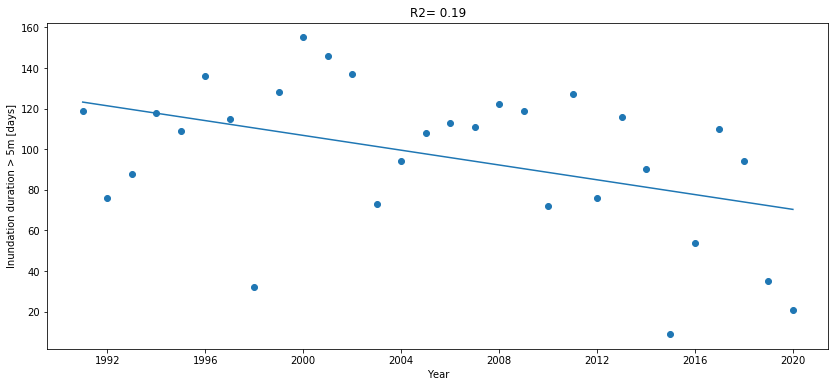

In [14]:
fig, ax = plt.subplots(1, figsize=(14, 6))

x = df['years']
x = date2num(pd.to_datetime(x))
y = df['flood_dur_5m']

ax.scatter(x,y )
ax.set_xlabel('Year')
ax.set_ylabel('Inundation duration > 5m [days]')

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = (correlation_xy**2).round(2)

ax.set_title("R2= " + str(r_squared))

# regression line
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

#plt.xticks(rotation = 45)

#ax.annotate("r-squared"+ str(r_squared), (0, 1))


axes = plt.gca()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%Y')


ax.xaxis.set_major_formatter(myFmt)

fig.savefig('Change_inundation_duration_5m_PA', dpi=100)

plt.show()

In [15]:
#### import area water level relationship => how large is the area that gets flooded at every water level step? 

area_wl = pd.read_csv('area_WL_PA.csv', sep=';')

area_wl = area_wl.sort_values('count')

area_wl = area_wl.set_index('count')

area_wl.head()

## link to flood link

flood_link_full = flood_link.merge(area_wl, how='inner', left_index=True, right_index=True)

flood_link_full.head()


,wl_KK,date,image_date,count_reached,area,cumulative_area
1,6.78,2018-08-29,2018-08-29,1,59622,1232410
2,6.78,2018-08-28,2018-08-28,2,40897,1172788
3,6.75,2018-09-09,2018-09-09,3,33992,1131891
4,6.74,2018-09-10,2018-09-10,4,34643,1097899
5,6.67,2019-09-16,2019-09-16,5,29465,1063256


In [16]:
##### calculates the maximum inundation extent for each year


def maximum_flood_extent_min(y): 

            #######
            # Get the wet season / dry season duration for year n & n+1 
            #######
            
            # cut to year y 
            
            wlnew = wl_original[(wl_original['year'] == y)] 
            
            # get maximum water level (height of dry season)
            wl_max = wlnew['wl_KK'].max() 
            
            # calculate the corresponding flood extent 
            
            # get extent at maximum level 
            max_extent = flood_link_full[(flood_link_full['wl_KK']>=wl_max)]  

            max_extent = max_extent['cumulative_area'].min()

            return max_extent 

        
        
def maximum_flood_extent_max(y): 

            #######
            # Get the wet season / dry season duration for year n & n+1 
            #######
            
            # cut to year y 
            
            wlnew = wl_original[(wl_original['year'] == y)] 
            
            # get maximum water level (height of dry season)
            wl_max = wlnew['wl_KK'].max() 
            
            # calculate the corresponding flood extent 
            
            # get extent at maximum level 
            max_extent = flood_link_full[(flood_link_full['wl_KK']<=wl_max)]  

            max_extent = max_extent['cumulative_area'].max()

            return max_extent 
        
        
def find_max_level(y): 

            #######
            # Get the wet season / dry season duration for year n & n+1 
            #######
            
            # cut to year y 
            
            wlnew = wl_original[(wl_original['year'] == y)] 
            
            # get maximum water level (height of dry season)
            wl_max = wlnew['wl_KK'].max() 
            

            return wl_max


In [17]:
df['max_extent_max'] = (df['years'].apply(maximum_flood_extent_max))
df['max_extent_min'] = (df['years'].apply(maximum_flood_extent_min))
df['max_level'] = (df['years'].apply(find_max_level))
df['max_extent'] = df[['max_extent_min', 'max_extent_max']].mean(axis=1)
df = df.drop(columns=['max_extent_min', 'max_extent_max'])

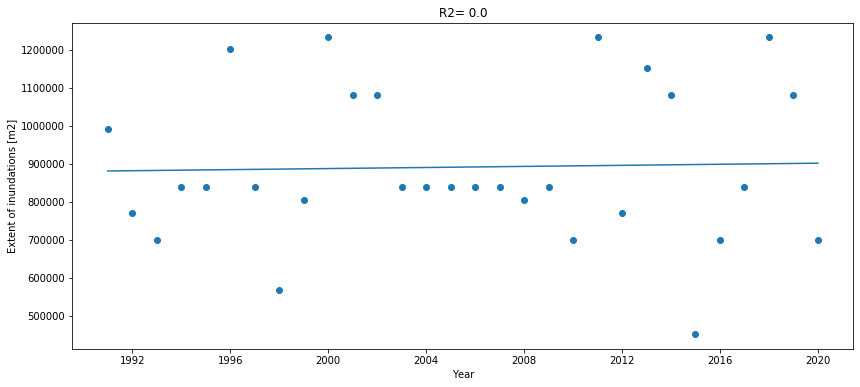

In [18]:
fig, ax = plt.subplots(1, figsize=(14, 6))

x = df['years']
x = date2num(pd.to_datetime(x))
y = df['max_extent']

ax.scatter(x,y )
ax.set_xlabel('Year')
ax.set_ylabel('Extent of inundations [m2]')

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = (correlation_xy**2).round(2)

ax.set_title("R2= " + str(r_squared))

# regression line
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

#plt.xticks(rotation = 45)

#ax.annotate("r-squared"+ str(r_squared), (0, 1))


axes = plt.gca()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%Y')


ax.xaxis.set_major_formatter(myFmt)

fig.savefig('Change_in_maximum_inundation_extents_PA', dpi=100)

plt.show()

In [19]:
#df.head(30)

In [24]:
####### AVERAGE INUNDATION EXTENT > 5m 

def average_inundation_extent(y): 

            #######
            # Get the wet season / dry season duration for year n & n+1 
            #######
            
            # cut to year y 
            wl_new = wl_original[(wl_original['year'] == y)] 
            
            
            ## subset the series to water levels above 5m 
            wl_above_total = wl_new[(wl_new['wl_KK'])>= 5]
            
            
            ## total number of days 
            wl_above_total_days = len(wl_above_total.index)
            
            #######
            #  get all the water levels for that period 
            #######

            wll_list = wl_above_total['wl_KK'].tolist()
            
            #######
            #  for each wl, calculate extent and duration and multiply by fraction of days! 
            #######
            
            # create new dataframe and write the duration and extents of each wl above 5 m 
            
            df_year = pd.DataFrame(columns = ['wl', 'duration', 'extent_min', 'extent_max'])
            
            for wl in wll_list: 
                
                wl_above_level_wl = wl_above_total[(wl_above_total['wl_KK'])>= wl]
            
                wl_above_total_days_wl = len(wl_above_level_wl.index)
                
                flood_extent_max = flood_link_full[(flood_link_full['wl_KK']<=wl)]  

                flood_extent_max = flood_extent_max['cumulative_area'].max()
                
                flood_extent_min = flood_link_full[(flood_link_full['wl_KK']>=wl)]  

                flood_extent_min= flood_extent_min['cumulative_area'].min()
                
                df_year = df_year.append(pd.DataFrame({'wl': wl, 'duration': wl_above_total_days_wl, 'extent_min': flood_extent_min, 'extent_max': flood_extent_max}, index=[0]), ignore_index=True)
                
                
            ## in duration column, create difference between rows but preserve the top one 
                                              
                                              
            
            
            df_year['extent'] = df_year[['extent_min', 'extent_max']].mean(axis=1)
            
            df_year['extent_weighed'] = df_year['wl']*df_year['duration']
            
            # caluclate the flood extent corresponding to that level 
            
            weighed_extents = (df_year['extent_weighed'].sum())/(df_year['duration'].sum())
            
            return weighed_extents
                               
                                              


In [25]:
df['average_extent'] = (df['years'].apply(average_inundation_extent))

In [26]:
df.head()

,years,flood_dur_5m,max_level,max_extent,average_extent
1991,1991,119,6.62,991743.5,5.757328
1992,1992,76,5.99,771597.5,5.403701
1993,1993,88,5.85,700856.0,5.347199
1994,1994,118,6.53,839896.0,5.872031
1995,1995,109,6.40,839896.0,5.732513


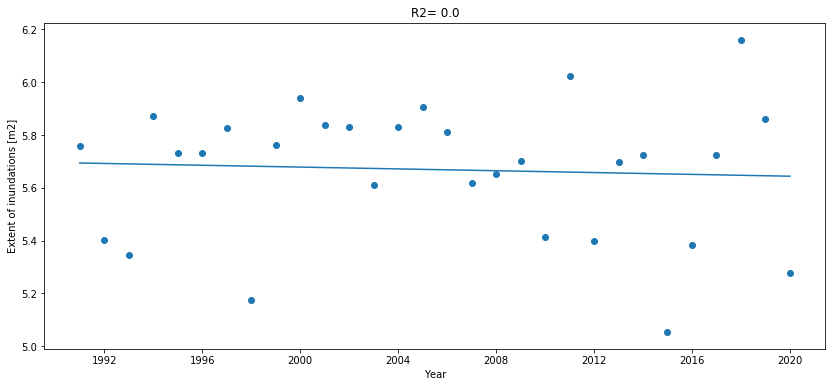

In [27]:
fig, ax = plt.subplots(1, figsize=(14, 6))

x = df['years']
x = date2num(pd.to_datetime(x))
y = df['average_extent']

ax.scatter(x,y )
ax.set_xlabel('Year')
ax.set_ylabel('Extent of inundations [m2]')

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = (correlation_xy**2).round(2)

ax.set_title("R2= " + str(r_squared))

# regression line
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

#plt.xticks(rotation = 45)

#ax.annotate("r-squared"+ str(r_squared), (0, 1))


axes = plt.gca()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%Y')


ax.xaxis.set_major_formatter(myFmt)

fig.savefig('Change_in_average_inundation_extents_PA', dpi=100)

plt.show()